In [ ]:
!pip install tensorflow==1.15

In [ ]:
NETWORK = 'Network' + '.py'

# Parametros


In [ ]:
# Image size
IMAGE_SIZE = 500

# Loss Weights
CONTENT_WEIGHT = 0.025
STYLE_WEIGHT = 1.0
STYLE_SCALE = 1.0
TOTAL_VARIATION_WEIGHT = 8.5e-5
CONTENT_LOSS_TYPE = 0

# Training arguments
NUM_ITERATIONS = 10
MODEL = 'vgg19'
RESCALE_IMAGE = 'false'
MAINTAIN_ASPECT_RATIO = 'false'  # Set to false if OOM occurs

# Transfer Arguments
CONTENT_LAYER = 'conv' + '5_2'  # only change the number 5_2 to something in a similar format
INITIALIZATION_IMAGE = 'content'
POOLING_TYPE = 'max'

# Extra arguments
PRESERVE_COLOR = 'false'
MIN_IMPROVEMENT = 0.0

# Imagen de contenido


In [ ]:
from google.colab import files
import os
content_img = files.upload()


CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp
  
print("Content image filename :", CONTENT_IMAGE_FN)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

Saving 18726-guard106.jpg to 18726-guard106.jpg


# Imagen de estilo

In [ ]:
style_img = files.upload()
STYLE_IMAGE_FN = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN.strip().replace(" ", "_")

if STYLE_IMAGE_FN != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN = STYLE_IMAGE_FN_temp

print("Style image filename :", STYLE_IMAGE_FN)
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_IMAGE_FN)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

Saving 56786.jpg to 56786.jpg


# Transferencia de estilo


In [ ]:
import os
RESULT_DIR = "generated/"
RESULT_PREFIX = RESULT_DIR + "gen"
FINAL_IMAGE_PATH = RESULT_PREFIX + "_at_iteration_%d.png" % (NUM_ITERATIONS)
if not os.path.exists(RESULT_DIR):
  os.makedirs(RESULT_DIR)

In [ ]:
!python {dir_path}/{NETWORK} {CONTENT_IMAGE_FN} {STYLE_IMAGE_FN} {RESULT_PREFIX} \
  --image_size {IMAGE_SIZE} --content_weight {CONTENT_WEIGHT} --style_weight \
  {STYLE_WEIGHT} --style_scale {STYLE_SCALE} --total_variation_weight \
  {TOTAL_VARIATION_WEIGHT} --content_loss_type {CONTENT_LOSS_TYPE} --num_iter \
  {NUM_ITERATIONS} --model {MODEL} --rescale_image {RESCALE_IMAGE} \
  --maintain_aspect_ratio {MAINTAIN_ASPECT_RATIO} --content_layer {CONTENT_LAYER} \
  --init_image {INITIALIZATION_IMAGE} --pool_type {POOLING_TYPE} --preserve_color \
  {PRESERVE_COLOR} --min_improvement {MIN_IMPROVEMENT}

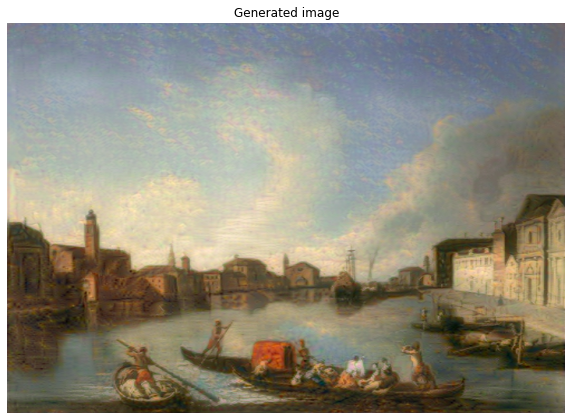

In [ ]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(FINAL_IMAGE_PATH)
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)

1
2
3
4
5
6
7
8
9
10


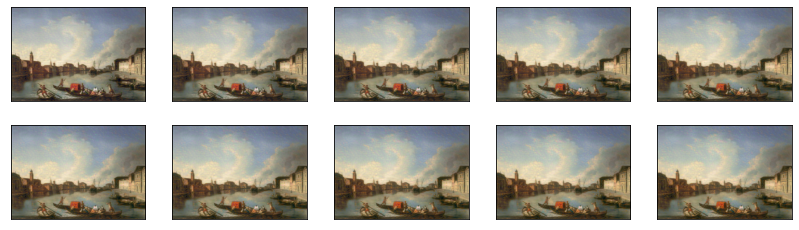

In [ ]:
plt.figure(figsize=(14,4))
imgs = []
for j in range(10):
  cont=j+1
  imagen = plt.imread('generated/gen_at_iteration_'+str(cont)+'.png')
  imgs.append(imagen)
for i,img in enumerate(imgs):
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])